In [126]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-marketing-dataset/bank.csv


Firstly, lets start from reading the dataset and looking it's info and numerical feature statistics

In [127]:
data = pd.read_csv("/kaggle/input/bank-marketing-dataset/bank.csv")
print(data.info())
print(data.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None
            count         mean          std     min    25%    50%      75%  \
age       11162.

So, in this dataset, we are provided with client data. Our target variable is deposit, and the task is to predict, whether some specific client will get a long term deposit or not. As it is a binary variable, it means that we are dealing with classification problem

Now, lets look at the distribution of this target variable, to see if it is balanced, or not.

<Axes: xlabel='deposit'>

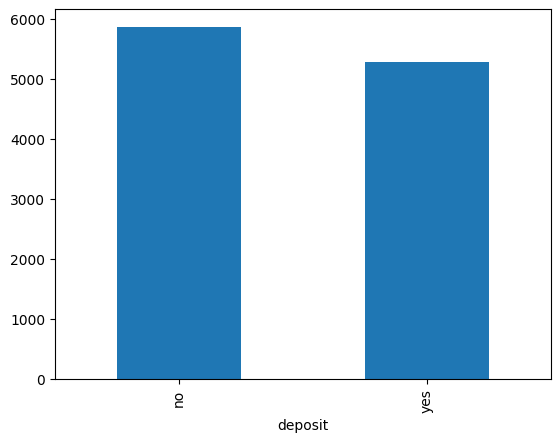

In [128]:
data.deposit.value_counts().plot(kind='bar')

We see that our target's distribution is balanced, it's good news for us, because it means that our model won't result in high bias 

Now, lets start preprocessing our data by first looking at our object variables and determining whether they are ordinal or categorical

In [129]:
object_cols = ["job", "marital", "education", "default", 
               "housing", "loan", "contact", "month", "deposit", "poutcome"]
for col in object_cols:
    print(data[col].value_counts())
    print("\n\n")

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64



marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64



education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64



default
no     10994
yes      168
Name: count, dtype: int64



housing
no     5881
yes    5281
Name: count, dtype: int64



loan
no     9702
yes    1460
Name: count, dtype: int64



contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64



month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: count, dtype: int64



deposit
no     5873
yes    5289
Name: count, dtype: 

So, the binary variables for us are deposit, loan, housing and default, we will replace them with ones and zeroes

In [130]:
binary_variables = ["deposit", "loan", "housing","default"]
for var in binary_variables:
    data[var] = data[var].map({"yes" : 1, "no" : 0})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  int64 
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  int64 
 7   loan       11162 non-null  int64 
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  int64 
dtypes: int64(11), object(6)
memory usage: 1.4+ MB


Now, lets look at ordinal variables, in our example, they are month,education and poutcome, we can't just one-hot encode them, because  order matters, so we will preprocess them like this

In [131]:
education_dict = {
    "unknown" : 0, 
    "primary" : 1, 
    "secondary" : 2, 
    "tertiary" : 3
}
data["education"] = data["education"].map(education_dict)
data["education"].value_counts()

education
2    5476
3    3689
1    1500
0     497
Name: count, dtype: int64

In [132]:
month_mapping = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}
data["month"] = data["month"].map(month_mapping)
data["month"].value_counts()

month
5     2824
8     1519
7     1514
6     1222
11     943
4      923
2      776
10     392
1      344
9      319
3      276
12     110
Name: count, dtype: int64

In [133]:
poutcome_dict = {
    "unknown" : 0, 
    "failure" : 1, 
    "other" : 2, 
    "success" : 3
}
data["poutcome"] = data["poutcome"].map(poutcome_dict)
data["poutcome"].value_counts()

poutcome
0    8326
1    1228
3    1071
2     537
Name: count, dtype: int64

Now, lets one-hot encode the categorical variables

In [134]:
data = pd.get_dummies(data, columns=["job", "marital", "contact"])


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                11162 non-null  int64
 1   education          11162 non-null  int64
 2   default            11162 non-null  int64
 3   balance            11162 non-null  int64
 4   housing            11162 non-null  int64
 5   loan               11162 non-null  int64
 6   day                11162 non-null  int64
 7   month              11162 non-null  int64
 8   duration           11162 non-null  int64
 9   campaign           11162 non-null  int64
 10  pdays              11162 non-null  int64
 11  previous           11162 non-null  int64
 12  poutcome           11162 non-null  int64
 13  deposit            11162 non-null  int64
 14  job_admin.         11162 non-null  bool 
 15  job_blue-collar    11162 non-null  bool 
 16  job_entrepreneur   11162 non-null  bool 
 17  job_housemai

Now, lets scale our numerical features

In [136]:
num_features = ["age", "balance", "day", "duration", 
                "campaign", "pdays", "previous", "poutcome",
               "month", "education"]

In [137]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[num_features] = scaler.fit_transform(data[num_features])
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,0.301714,0.154719,0.0,0.181818,0.272727,0.402597,1.0
education,11162.0,0.702353,0.264907,0.0,0.666667,0.666667,1.000000,1.0
default,11162.0,0.015051,0.121761,0.0,0.000000,0.000000,0.000000,1.0
balance,11162.0,0.095121,0.036631,0.0,0.079147,0.084008,0.097160,1.0
housing,11162.0,0.473123,0.499299,0.0,0.000000,0.000000,1.000000,1.0
loan,11162.0,0.130801,0.337198,0.0,0.000000,0.000000,0.000000,1.0
day,11162.0,0.488601,0.280691,0.0,0.233333,0.466667,0.700000,1.0
month,11162.0,0.471893,0.233890,0.0,0.363636,0.454545,0.636364,1.0
duration,11162.0,0.095384,0.089489,0.0,0.035061,0.065223,0.127352,1.0
campaign,11162.0,0.024329,0.043904,0.0,0.000000,0.016129,0.032258,1.0


Great, now, lets split our data in training and test datasets

In [138]:
X, y = data.drop("deposit", axis=1), data.deposit

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=54)

And now, it's finally time to build and train our model

In [146]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7) 

In [147]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [148]:
y_pred = knn.predict(X_valid)

In [149]:
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(y_valid, y_pred))

Accuracy: 0.7017465293327362


Okay, the model is trained, and we have also gotten a decent accuracy result, now, let's find the most optimal number of neighbours for this model using cross validation

In [154]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=54)
knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, X, y, cv=kf, scoring='f1')
print("metric value array", scores)
print("average cross validation metric", np.mean(scores))

metric value array [0.653125   0.66765726 0.63513514 0.68302658 0.68137255]
average cross validation metric 0.6640633050178357


In this example, I used f1 score instead of plain accuracy, because it also shows us how well the model is at detecting all positive cases in our data

Now, let's conduct a cross validation with grid search

In [155]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

knn_params = {'n_neighbors': np.arange(1, 50, 1)} # словарь гиперпараметров (ключ: набор возможных значений)

knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='f1') # кросс-валидация по 5 блокам
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='f1')

In [156]:
print("best params: ", knn_grid.best_params_)

print("best model: ",knn_grid.best_estimator_)

best params:  {'n_neighbors': 1}
best model:  KNeighborsClassifier(n_neighbors=1)


In [157]:
pd.DataFrame(knn_grid.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
mean_fit_time,0.006829,0.006716,0.006543,0.006464,0.006287,0.006521,0.006932,0.006442,0.006453,0.006411,...,0.0064,0.006491,0.006491,0.00641,0.007628,0.006526,0.006528,0.006501,0.006445,0.006393
std_fit_time,0.000719,0.00022,0.000223,0.000134,0.000121,0.000175,0.000554,0.000106,0.000149,0.000195,...,0.000169,0.000227,0.000156,0.000185,0.002326,0.000202,0.000364,0.000227,0.000232,0.000128
mean_score_time,0.126972,0.136206,0.130342,0.144035,0.230445,0.134934,0.140482,0.137141,0.13353,0.134177,...,0.16234,0.160261,0.163402,0.165956,0.171454,0.163165,0.164243,0.167964,0.165161,0.165034
std_score_time,0.001956,0.010678,0.002278,0.01648,0.131568,0.002586,0.007956,0.004367,0.000678,0.001054,...,0.00853,0.005131,0.006104,0.00918,0.009308,0.002149,0.00357,0.005265,0.003662,0.00444
param_n_neighbors,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
params,{'n_neighbors': 1},{'n_neighbors': 2},{'n_neighbors': 3},{'n_neighbors': 4},{'n_neighbors': 5},{'n_neighbors': 6},{'n_neighbors': 7},{'n_neighbors': 8},{'n_neighbors': 9},{'n_neighbors': 10},...,{'n_neighbors': 40},{'n_neighbors': 41},{'n_neighbors': 42},{'n_neighbors': 43},{'n_neighbors': 44},{'n_neighbors': 45},{'n_neighbors': 46},{'n_neighbors': 47},{'n_neighbors': 48},{'n_neighbors': 49}
split0_test_score,0.674699,0.557864,0.648345,0.592958,0.655717,0.601955,0.640356,0.604167,0.642674,0.617708,...,0.608054,0.622715,0.612,0.625735,0.613651,0.620013,0.610596,0.62069,0.615079,0.622715
split1_test_score,0.667076,0.55647,0.673171,0.602797,0.673993,0.618084,0.675245,0.636605,0.663777,0.643754,...,0.635171,0.641339,0.634754,0.643041,0.637738,0.638961,0.628723,0.632334,0.623599,0.63103
split2_test_score,0.67362,0.575893,0.678175,0.628331,0.672968,0.632384,0.667949,0.620929,0.654616,0.627827,...,0.627845,0.641192,0.628989,0.642581,0.634017,0.639228,0.626667,0.639334,0.629556,0.640464
split3_test_score,0.666667,0.546677,0.668311,0.611732,0.67204,0.608155,0.646232,0.614217,0.655738,0.618331,...,0.637588,0.64326,0.633355,0.638245,0.63301,0.638539,0.628645,0.645649,0.625568,0.638137


Okay, let's plot the graph to see all of the information about number of neighbors

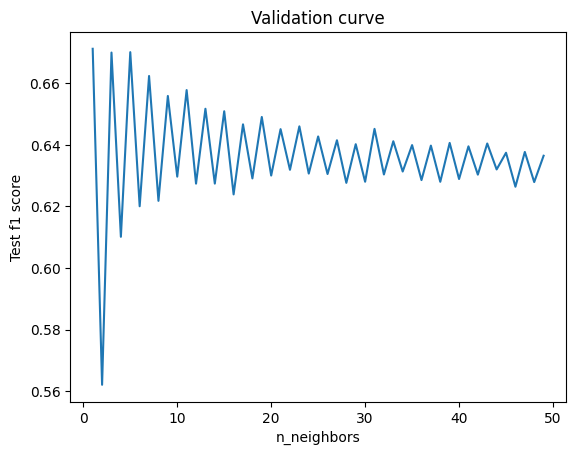

In [158]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame(knn_grid.cv_results_)
plt.plot(results_df['param_n_neighbors'], results_df['mean_test_score'])

plt.xlabel('n_neighbors')
plt.ylabel('Test f1 score')
plt.title('Validation curve')
plt.show()

For the final part of this assignment, lets experiment with minkowsky metric hyperparameters

In [159]:
p_values = np.linspace(1, 10, 20)
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
mean_scores = {}

for p in p_values:
    knn.p = p
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    mean_scores[p] = np.mean(scores)

best_p = max(mean_scores, key=mean_scores.get)
best_score = mean_scores[best_p]

print(f"Optimal p value: {best_p}")
print(f"Best accuracy: {best_score:.2f}")


Optimal p value: 1.4736842105263157
Best accuracy: 0.66


We see that the optimal p_value is 1.47
Now, lets experiment with other metrical models like NearestCentroid and RadiusNeighborsClassifier

In [179]:
from sklearn.neighbors import RadiusNeighborsClassifier
neigh = RadiusNeighborsClassifier(radius=1.9)
neigh.fit(X_train, y_train)

RadiusNeighborsClassifier(radius=1.9)

In [180]:
y_pred = neigh.predict(X_valid)


In [181]:
print('Accuracy:', accuracy_score(y_valid, y_pred))

Accuracy: 0.6650246305418719


I have experimented with the radius hyperparameter, and the best accuracy is achieved at 1.9

Now, lets try the nearest centroid model

In [182]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(X_train, y_train)

NearestCentroid()

In [183]:
y_pred = clf.predict(X_valid)


In [184]:
print('Accuracy:', accuracy_score(y_valid, y_pred))

Accuracy: 0.6462158531124048


That concludes the assignment, in the end, the best performing model is a KNN model, it gave us a 70% accuracy